In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import math
import statsmodels.api as sm
import warnings
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

In [2]:
#Importing Files from Competition

games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')
tackles = pd.read_csv('tackles.csv')

### Game EDA

In [3]:
print('Number of Weeks: ', games['week'].nunique())
print('Number of Games: ', games['gameId'].nunique())

Number of Weeks:  9
Number of Games:  136


In [4]:
#Describing Score Metrics

print('Home Team Score: ')
games.homeFinalScore.describe()

print('Visitor Team Score: ')
games.visitorFinalScore.describe()

Home Team Score: 


count    136.000000
mean      22.669118
std        8.659874
min        3.000000
25%       17.000000
50%       22.500000
75%       27.000000
max       49.000000
Name: homeFinalScore, dtype: float64

Visitor Team Score: 


count    136.000000
mean      20.948529
std        9.731446
min        0.000000
25%       14.750000
50%       20.000000
75%       27.000000
max       48.000000
Name: visitorFinalScore, dtype: float64

In [5]:
#Converting gameDate to DateTime for Day of Week Analysis
games['gameDate'] = pd.to_datetime(games['gameDate'])

#Finding Day of Week
games['dayOfWeek'] = games['gameDate'].dt.day_name()

#Denoting if Game is Primetime
games['primeTime'] = 'No'
games.loc[games.dayOfWeek == 'Thursday', 'primeTime'] = 'Yes'
games.loc[games.dayOfWeek == 'Monday', 'primeTime'] = 'Yes'
games.loc[(games.dayOfWeek == 'Sunday') & (games.gameTimeEastern.str[0:2] == '20'), 'primeTime'] = 'Yes'

### Tracking EDA

In [6]:
#Importing Tracking from Week 1
tracking_1 = pd.read_csv('tracking_week_1.csv')
tracking_1['x'] = tracking_1.x.round(2)

### Play Animation

In [7]:
tracking_1.groupby(['gameId','playId'])['frameId',].max().reset_index().sort_values(by = ['frameId'])

,gameId,playId,frameId
861,2022091108,171,11
73,2022090800,2979,11
1010,2022091109,2824,11
1301,2022091113,155,11
1388,2022091200,156,11
...,...,...,...
336,2022091102,2738,95
1257,2022091112,2246,95
686,2022091105,4905,98
902,2022091108,1948,111


In [8]:
GAMEID = 2022090800
PLAYID = 80

In [9]:
data = tracking_1[(tracking_1.gameId == GAMEID) & (tracking_1.playId == PLAYID)]
tackle_data = tackles[(tackles.gameId == GAMEID)&(tackles.playId == PLAYID)].reset_index(drop = True)
play_data = plays[(plays.gameId == GAMEID)&(plays.playId == PLAYID)].reset_index(drop=True)

In [10]:
#Creates Empty Lists for Tacklers, Missed Tackles, Assits, and Forced Fumbles
tackles_list = []
missed_tackles = []
assists = []
forcedFumbles = []

#Iterates through the Tack Data and Identifies the above acategories, appends to the list
for row in range(len(tackle_data)):
    if tackle_data.iloc[row]['tackle'] == 1:
        tackles_list.append(tackle_data.iloc[row].nflId)
    if tackle_data.iloc[row]['assist'] == 1:
        assists.append(tackle_data.iloc[row].nflId)
    if tackle_data.iloc[row]['forcedFumble'] == 1:
        forcedFumbles.append(tackle_data.iloc[row].nflId)
    if tackle_data.iloc[row]['pff_missedTackle'] == 1:
        missed_tackles.append(tackle_data.iloc[row].nflId)
       

#Identifies the Ball Carrier
ball_carrier = int(play_data['ballCarrierId'])

In [11]:
#Labels Players in tracking data that are ball carrier, tackler, assist, FF, and missed Tackles
data.loc[data['nflId'] == ball_carrier, 'tag'] = 'ballCarrier'

data.loc[data['nflId'].isin(tackles_list), 'tackle'] = 1
data.loc[data['nflId'].isin(assists), 'assist'] = 1
data.loc[data['nflId'].isin(forcedFumbles), 'forcedFumble'] = 1
data.loc[data['nflId'].isin(missed_tackles), 'missedTackle'] = 1

In [12]:
ball_carrier_xy = []
ball_data = data[data.tag == 'ballCarrier']
all_tacklers = tackles_list + missed_tackles + forcedFumbles + assists

#Finds distance from tacklers to the ball_carrier
for frame in list(data.frameId.sort_values().unique()):
    
    #Get xy coords for ball_carrier
    ball_carrier_xy = ball_data[ball_data.frameId == frame][['x','y']].values.flatten().tolist()
    
    for player in all_tacklers:
        #Get xy coords for tackler
        tackler_xy = data[(data.nflId == player)&(data.frameId == frame)][['x','y']].values.flatten().tolist()

        #Finds Distance from Ball Carrier to Tackler and appends it in dataframe
        distance_from_carrier = math.dist(ball_carrier_xy, tackler_xy)
        data.loc[(data.frameId == frame) & (data.nflId == player), 'distanceFromCarrier'] = distance_from_carrier
    
    #Get xy coords for ball_carier
    carrier_xy = data[(data.displayName == 'football')&(data.frameId == frame)][['x','y']].values.flatten().tolist()

    #Finds Distance from Ball Carrier to Tackler and appends it in dataframe
    distance_from_carrier = math.dist(ball_carrier_xy, carrier_xy)
    data.loc[(data.frameId == frame) & (data.displayName == 'football'), 'distanceFromCarrier'] = distance_from_carrier
        
football_xy = []
football_data = data[data.displayName == 'football']

#Finds distance from ballcarier to the football to know when he has the ball
for frame in list(data.frameId.sort_values().unique()):
    
    #Get xy coords for ball_carrier
    football_xy = football_data[football_data.frameId == frame][['x','y']].values.flatten().tolist()
    
    #Get xy coords for ball_carier
    carrier_xy = data[(data.tag == 'ballCarrier')&(data.frameId == frame)][['x','y']].values.flatten().tolist()

    #Finds Distance from Ball Carrier to Tackler and appends it in dataframe
    distance_from_football = math.dist(football_xy, carrier_xy)
    data.loc[(data.frameId == frame) & (data.tag == 'ballCarrier'), 'distanceFromCarrier'] = distance_from_football

In [13]:
data.loc[(data.distanceFromCarrier < 2)&(data.tackle == 1), 'club'] = 'Tackle'
data.loc[(data.distanceFromCarrier < 2)&(data.missedTackle == 1), 'club'] = 'MissedTackle'
data.loc[(data.distanceFromCarrier < 2)&(data.assist == 1), 'club'] = 'assist'
data.loc[(data.distanceFromCarrier < 0.5)&(data.forcedFumble == 1), 'club'] = 'forcedFumble'

data.loc[(data.distanceFromCarrier < 1.5)&(data.tag == 'ballCarrier'), 'club'] = 'ballCarrier'
data.loc[(data.distanceFromCarrier < 1.5)&(data.displayName == 'football'), ['x','y']] = np.nan

In [14]:
num_of_missed = data[data.missedTackle==1]['nflId'].nunique()
num_of_tackles = data[data.tackle == 1]['nflId'].nunique()
num_of_assists = data[data.assist == 1]['nflId'].nunique()
num_of_fumbles = data[data.forcedFumble == 1]['nflId'].nunique()

for frame in list(data.frameId.sort_values().unique()):
    
    missing_players = num_of_missed - data[(data.frameId == frame)&(data.club == 'MissedTackle')]['missedTackle'].sum()
    for i in range(int(missing_players)):
        data = pd.concat([data, pd.DataFrame({'frameId':frame, 'club':'MissedTackle'}, index = [0])])
        
    missing_players = num_of_tackles - data[(data.frameId == frame)&(data.club == 'Tackle')]['tackle'].sum()
    for i in range(int(missing_players)):
        data = pd.concat([data, pd.DataFrame({'frameId':frame, 'club':'Tackle'}, index = [0])])
        
    missing_players = num_of_assists - data[(data.frameId == frame)&(data.club == 'assist')]['assist'].sum()
    for i in range(int(missing_players)):
        data = pd.concat([data, pd.DataFrame({'frameId':frame, 'club':'assist'}, index = [0])])

    missing_players = num_of_fumbles - data[(data.frameId == frame)&(data.club == 'forcedFumble')]['forcedFumble'].sum()
    for i in range(int(missing_players)):
        data = pd.concat([data, pd.DataFrame({'frameId':frame, 'club':'forcedFumble'}, index = [0])])
        
    if not math.isnan(data[(data.frameId == frame)&(data.displayName == 'football')]['x']):
        data = pd.concat([data, pd.DataFrame({'frameId':frame, 'club':'ballCarrier'}, index = [0])])

In [15]:
#Replacing Team names with Offense and Defense

data['club'] = data['club'].replace(play_data.iloc[0]['possessionTeam'], 'Offense')
data['club'] = data['club'].replace(play_data.iloc[0]['defensiveTeam'], 'Defense')

data = data.rename(columns = {'club':'Player of Interest'})

In [29]:
#Changing the Direction Stats to Have All PLays moving to the same way for training
data.loc[data.playDirection == 'left', 'x'] = 120 - data[data.playDirection == 'left']['x']
data.loc[data.playDirection == 'left', 'y'] = 53.3 - data[data.playDirection == 'left']['y']
data.loc[data.playDirection == 'left', 'o'] = 360 - data[data.playDirection == 'left']['o']
data.loc[data.playDirection == 'left', 'dir'] = 360 - data[data.playDirection == 'left']['dir']

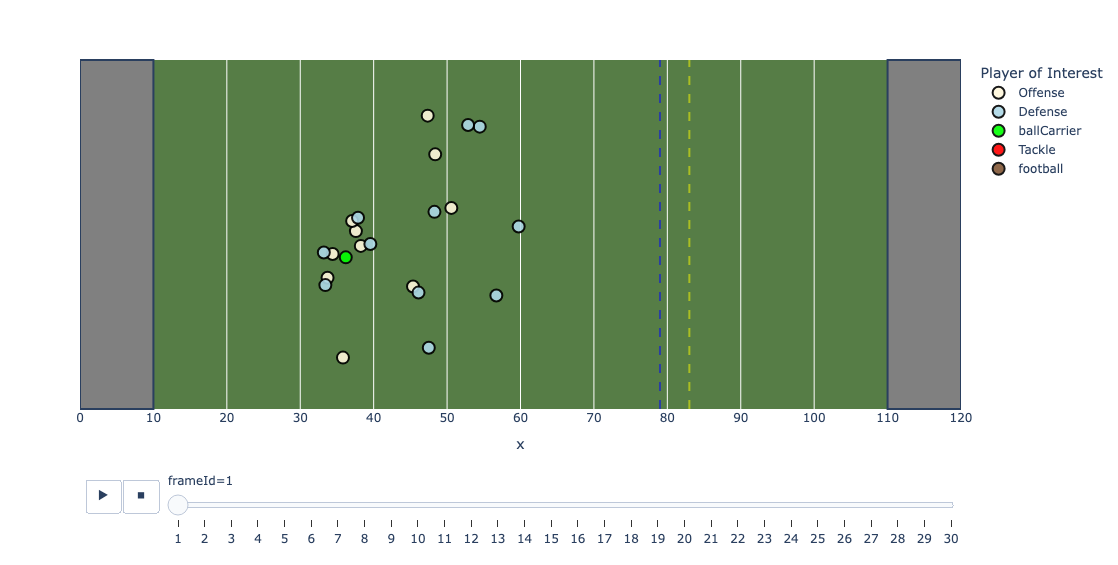

In [30]:
#temp_data = data[data.Player of Interest != 'football']
color_mapping = {
    'Offense': 'cornsilk',
    'Defense': 'lightblue',
    'football': 'brown',
    'Tackle': 'red',
    'MissedTackle': 'gold',
    'football':'#825736',
    'ballCarrier': 'lime',
    'assist':'darkorange',
    'forcedFumble':'fuchsia'
}

fig = fig = px.scatter(data, x = 'x', y = 'y', range_x = [0,120], range_y = [0, 53.3],
          color = 'Player of Interest', animation_frame = 'frameId', hover_name = 'displayName',
          color_discrete_map=color_mapping, width=1000, height=565)

fig = fig.add_vrect(x0=0, x1=10, fillcolor = 'gray')
fig = fig.add_vrect(x0=110, x1=120, fillcolor = 'gray')
fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']), line_dash="dash", 
                    line_color="blue", opacity = 0.5)
fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']) + int(play_data['yardsToGo']),
                    line_dash="dash", line_color="yellow", opacity = 0.5)
fig = fig.update_layout(
    plot_bgcolor='#567D46'
)
fig = fig.update_yaxes(visible=False)
fig = fig.update_layout(xaxis=dict(
    tick0=0,
    dtick=10,))

fig = fig.update_traces(marker=dict(size=12,line=dict(width=2,color='black'), opacity=0.9),
                  selector=dict(mode='markers'))

# Set frame duration to 100ms
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100

# Set transition xduration between frames to 0ms
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0

fig

In [35]:
players[players.nflId == 47857.0]

,nflId,height,weight,birthDate,collegeName,position,displayName
830,47857,5-7,203,1997-09-03,Florida Atlantic,RB,Devin Singletary


In [40]:
players[players.displayName == '''A'Shawn Robinson''']

,nflId,height,weight,birthDate,collegeName,position,displayName
315,43335,6-4,330,1995-03-21,Alabama,DT,A'Shawn Robinson
